# **Simulation Case Study: Predator-Prey Lotka-Volterra**
@author: Niklas Moser

@date: 03/05/2024

This notebook contains the analysis of the simulation case study. As this is a proof of concept, we simplify the analysis to not deal with elaborate hyperparameter and architecture search schemes but rather set those hyperparameters to some arbitrary value. Further, to make use of the simplicity and speed-up advantages of [JAX](https://jax.readthedocs.io/en/latest/), we decide to showcase the analysis here with JAX and not with PyTorch.

In our analysis we compare the performance of PiNNs, at the example of the parallel physics model, with a baseline deep neural network and the process model. The comparative analysis tests the performance under three conditions: (1) data sparsity, (2) data sparsity + structural error in the process model, (3) data sparsity + structural error in the process model + observation noise. Note that in (1) we assume that the process model is the same as the data-generating model and thus shows no structural error, but in (2)-(3) we introduce a simplified process model to generate the structural mismatch between process model and data-generating model.


## Data-generating model
We model the density of prey $x$ and predators $y$ as
\begin{equation}
\frac{dx_t}{dt} = rx_t - b\frac{x_t^2y_t}{1 + sx_t^2},
\end{equation}
\begin{equation}
\frac{dy_t}{dt} = b\frac{x_t^2y_t}{1 + sx_t^2} - my_t,
\end{equation}
where $r$ is the growth rate of prey, $m$ is the mortality rate of predators, and $b$ is the interspecific competition or feeding rate of predators. Note that we include here a Holling type III functional response for the feeding rate with prey searching time $s$.

We simulate from the data-generating model the densities of predators and prey over 130 time units with initial densities $x_0 = 10, y_0 = 10$ and parameter values $r=0.1,b=0.02, m=0.04,s=0.025$.

From this time series, we observe the density of prey at 9 random time points. In the Figure below we show the time series (lines) and observations (dots).


## Process model
In (1) the process-based model matches exactly with the data-generating model. In (2)-(3) we use a simplified version of the data-generating model where we change the type III to a type I functional response. The process model is thus
\begin{equation}
\frac{dx_t}{dt} = rx_t - bx_ty_t,
\end{equation}
\begin{equation}
\frac{dy_t}{dt} = bx_ty_t - my_t,
\end{equation}

where we assume that predators immediately feed on prey ($s=0$).


In [1]:
# Install JAX compatible ODE solver
%%capture
%pip install diffrax

In [2]:
import jax
import diffrax
import optax
import jax.numpy as jnp
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy as np

# (1) Data sparsity

In [3]:
# define ODE
def lv_vector_field(t, y, args):
  prey, predator = y
  r, b, m, s = args
  d_prey = prey*r  - b*(prey**2*predator)/(1 + s*prey**2)
  d_predator = b*(prey**2*predator)/(1 + s*prey**2) - m*predator
  d_y = d_prey, d_predator
  return d_y

def process_model(parms, idx):
  t0 = 0
  t1 = 130
  dt0 = 1
  y0 = (10, 10) # Assume we know the initial condition
  args = parms # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = idx)
  term = diffrax.ODETerm(lv_vector_field)
  solver = diffrax.Tsit5()
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  return sol.ys[0]

def pm_squared_loss(parms, y, idx):
  preds = process_model(parms, idx)
  return jnp.mean((preds - y)**2)

# Get adam from optax, set learning rate to 1e-3
adam = optax.adam(learning_rate=1e-5)

@jax.jit
def pm_update_adam(params, opt_state, y, idx):
  loss, grads = jax.value_and_grad(pm_squared_loss, allow_int=True)(params, y, idx)
  updates, opt_state = adam.update(grads, opt_state)
  params += jnp.stack(updates)
  return params, opt_state, loss

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/lax_numpy.py:2600: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/lax_numpy.py:2601: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is

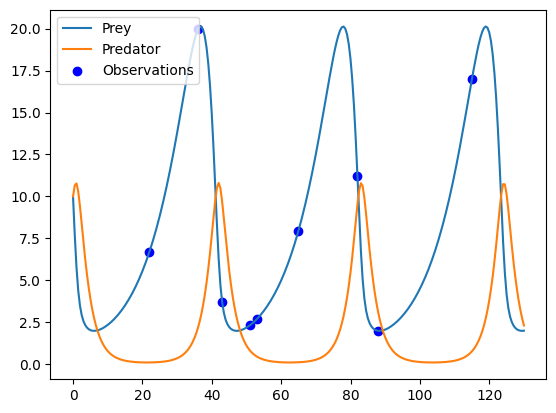

In [4]:
# True dynamics
term = diffrax.ODETerm(lv_vector_field)
solver = diffrax.Tsit5()
t0 = 0
t1 = 130
dt0 = .5
y0 = (10, 10)
args = (0.1, .02, .4, 0.025)
saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, 261))
sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
sparse_idx=jnp.sort(npr.RandomState(5).choice(jnp.linspace(1, t1, t1, dtype=int), 9, replace=False))
true_op = sol.ys[0]
true_time = sol.ts
obs= sol.ys[0][sparse_idx*2]
plt.plot(sol.ts, sol.ys[0], label="Prey")
plt.plot(sol.ts, sol.ys[1], label="Predator")
plt.scatter(sparse_idx, obs, color="blue", label="Observations")
plt.legend()
plt.show()

In [5]:
# LOO CV
pm_all = []
for i in range(9):
  obscv = obs[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  train_iters=60000
  pm_params = jnp.array((0.1, .02, .4, 0.025) + npr.RandomState(5).normal(0,.01, 4))
  os = adam.init(pm_params)
  losses = []
  for i in range(train_iters):
    pm_params, os, loss = pm_update_adam(pm_params, os, obscv, idxcv)
    losses.append(loss)
  pm_all.append(pm_params)
  print(loss)

1.1910474e-05
0.00012584342
3.137406e-05
1.2793501e-05
1.6806835e-05
6.858281e-05
6.727852e-07
1.165243e-05
2.1650207e-05


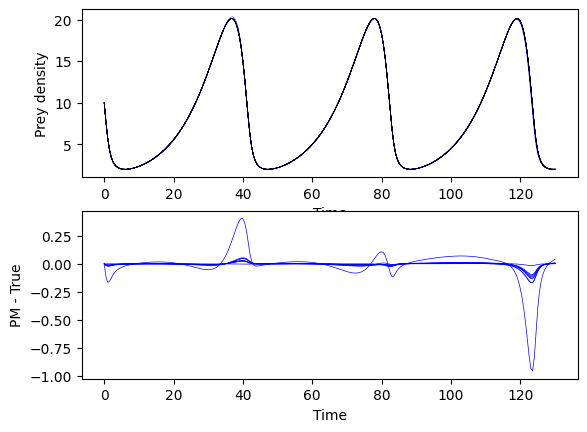

In [6]:
pm_op = []
for i in range(9):
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, 261))
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  pm_op.append(sol.ys[0])
  pm_time = sol.ts


fig, ax = plt.subplots(2)
for i in range(9):
  ax[0].plot(pm_time, pm_op[i], lw=.3, color="blue", label="PM predictions")
  ax[0].plot(pm_time, true_op, lw=0.5, color="black", label="True values")
  ax[0].set_xlabel('Time')
  ax[0].set_ylabel('Prey density')

  ax[1].plot(pm_time, pm_op[i] - true_op, lw=0.5, color="blue")
  ax[1].set_xlabel('Time')
  ax[1].set_ylabel('PM - True')

In [7]:
# Definitions for PiNN and NN
def parphy(p, inp, yhat):
  for w, b in p:
    o = jnp.dot(inp, w) + b
    inp = jnp.tanh(o)
  return o + yhat

def naive(p, inp, yhat):
  for w, b in p:
    o = jnp.dot(inp, w) + b
    inp = jnp.tanh(o)
  return o

def squared_loss(p, i, yhat, model, tt):
  preds = model(p, i, yhat)
  return jnp.mean((preds - tt)**2)

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

adam = optax.adam(learning_rate=1e-4)

@jax.jit
def pp_update_adam(params, opt_state, ip, yhh, tt):
  loss, grads = jax.value_and_grad(squared_loss)(params, ip, yhh, parphy, tt)
  updates, opt_state = adam.update(grads, opt_state)
  params = [(params[0][0] + updates[0][0], params[0][1] + updates[0][1]),
          (params[1][0] + updates[1][0], params[1][1] + updates[1][1]),
            (params[2][0] + updates[2][0], params[2][1] + updates[2][1])]
  return params, opt_state, loss

@jax.jit
def mlp_update_adam(params, opt_state, ip, tt):
  loss, grads = jax.value_and_grad(squared_loss)(params, ip, None, naive, tt)
  updates, opt_state = adam.update(grads, opt_state)
  params = [(params[0][0] + updates[0][0], params[0][1] + updates[0][1]),
          (params[1][0] + updates[1][0], params[1][1] + updates[1][1]),
            (params[2][0] + updates[2][0], params[2][1] + updates[2][1])]
  return params, opt_state, loss

In [8]:
# LOO CV with PiNN and NN
layer_sizes = [3 , 50, 50, 1]
param_scale = 1.0
train_iters= 200000


allpp_params = []
allmlp_params = []
for i in range(9):

  obscv = obs[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = idxcv)
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  # prepare inputs
  inputs = obscv[:-1]
  targets = obscv[1:]
  rop = sol.ys[0]
  yh = rop[:-1]
  inputs = jnp.reshape(inputs, (7,1))
  targets = jnp.reshape(targets, (7,1))
  yh = jnp.reshape(yh, (7,1))
  inputs=jnp.hstack((inputs, jnp.reshape(idxcv[:-1], (7,1)), jnp.reshape(idxcv[1:], (7,1))))

  pp_params = init_random_params(param_scale, layer_sizes)
  mlp_params = init_random_params(param_scale, layer_sizes)
  os = adam.init(pp_params)
  mlp_os = adam.init(pp_params)
  losses=[]
  mlp_losses = []
  for i in range(train_iters):
    pp_params, os, loss = pp_update_adam(pp_params, os, inputs, yh, targets)
    losses.append(loss)
    mlp_params, mlp_os, mlp_loss = mlp_update_adam(mlp_params, mlp_os, inputs, targets)
    mlp_losses.append(mlp_loss)
  allpp_params.append(pp_params)
  allmlp_params.append(mlp_params)
  print(loss, mlp_loss)

8.286902e-09 3.1008676e-09
2.7685995e-10 5.962469e-12
2.0042185e-06 2.0616235e-09
3.5137355e-09 8.121198e-06
6.515821e-06 1.5812664e-07
1.2423948e-05 3.1022296e-11
1.073691e-10 1.2913814e-06
1.1547335e-11 0.0
2.043927e-11 1.2265168e-07


In [9]:
# Average create figure with mean and cv preds
pred_pm_sparse = np.empty(shape=(7,9))
pred_mlp_sparse = np.empty(shape=(7,9))
pred_pp_sparse = np.empty(shape=(7,9))

pred_pm_full = np.empty(shape=(260,9))
pred_mlp_full = np.empty(shape=(260,9))
pred_pp_full = np.empty(shape=(260,9))

idx_sparse = np.empty(shape=(7,9))
obs_sparse = np.empty(shape=(7,9))

for i in range(9):
  obscv = obs[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  obs_sparse[:,i] = obscv[1:]
  idx_sparse[:,i] = idxcv[1:]
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = idxcv)
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  # prepare inputs
  inputs = obscv[:-1]
  targets = obscv[1:]
  rop = sol.ys[0]

  pred_pm_sparse[:,i] = rop[1:]

  yh = rop[:-1]
  inputs = jnp.reshape(inputs, (7,1))
  targets = jnp.reshape(targets, (7,1))
  yh = jnp.reshape(yh, (7,1))
  inputs=jnp.hstack((inputs, jnp.reshape(idxcv[:-1], (7,1)), jnp.reshape(idxcv[1:], (7,1))))
  fine_inputs = inputs

  pred_pp_sparse[:,i] = np.reshape(parphy(allpp_params[i], fine_inputs, yh), (7,))
  pred_mlp_sparse[:,i] = np.reshape(naive(allmlp_params[i], fine_inputs, None), (7,))


  ip = jnp.hstack((jnp.reshape(true_op[:-1], (260,1)),  jnp.reshape(true_time[:-1], (260,1)), jnp.reshape(true_time[1:], (260,1)))) #jnp.reshape(true_time[1:] - true_time[:-1], (99,1))))
  yha = jnp.reshape(pm_op[i][:-1], (260,1))

  pred_pp_full[:,i] = np.reshape(parphy(allpp_params[i], ip, yha), (260,))
  pred_mlp_full[:,i] = np.reshape(naive(allmlp_params[i], ip, None), (260,))
  pred_pm_full[:,i] = np.reshape(pm_op[i][1:], (260,))

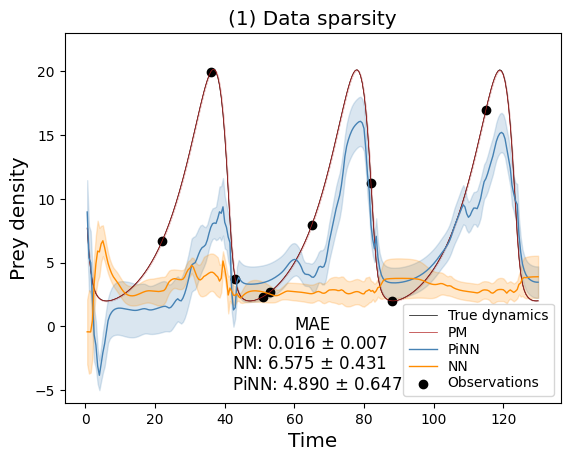

In [10]:
pm_full_mn = jnp.mean(pred_pm_full, axis=1)
pm_full_sd = jnp.std(pred_pm_full, axis=1)
mlp_full_mn = jnp.mean(pred_mlp_full, axis=1)
mlp_full_sd = jnp.std(pred_mlp_full, axis=1)
pp_full_mn = jnp.mean(pred_pp_full, axis=1)
pp_full_sd = jnp.std(pred_pp_full, axis=1)

pm_mae = jnp.array([jnp.mean(abs(pred_pm_full[:,j] - true_op[1:])) for j in range(9)])
mlp_mae = jnp.array([jnp.mean(abs(pred_mlp_full[:,j] - true_op[1:])) for j in range(9)])
pp_mae = jnp.array([jnp.mean(abs(pred_pp_full[:,j] - true_op[1:])) for j in range(9)])

fig, ax = plt.subplots(1)
ax.plot(true_time[1:], true_op[1:], lw=0.5, color='black', label="True dynamics")

ax.fill_between(true_time[1:], (pm_full_mn + pm_full_sd/jnp.sqrt(9)), (pm_full_mn - pm_full_sd/jnp.sqrt(9)), color="firebrick", alpha=0.2)
ax.plot(true_time[1:], pm_full_mn, lw=0.5, color='firebrick', label="PM")

ax.fill_between(true_time[1:], (pp_full_mn + pp_full_sd/jnp.sqrt(9)), (pp_full_mn - pp_full_sd/jnp.sqrt(9)), color="steelblue", alpha=0.2)
ax.plot(true_time[1:],  pp_full_mn, lw=1, color='steelblue', label="PiNN")

ax.fill_between(true_time[1:], (mlp_full_mn + mlp_full_sd/jnp.sqrt(9)),  (mlp_full_mn - mlp_full_sd/jnp.sqrt(9)), color="darkorange", alpha=0.2)
ax.plot(true_time[1:],  mlp_full_mn, lw=1, color='darkorange', label="NN")

ax.scatter(sparse_idx, obs, color="black", label="Observations")
ax.text(60, -0.3, "MAE",fontsize='large', fontweight="roman")
ax.text(42, -5, r"PM: {er:.3f} $\pm$ {se:.3f}" "\n" r"NN: {erm:.3f} $\pm$ {sem:.3f}""\n" r"PiNN: {erp:.3f} $\pm$ {sep:.3f}".format(
    er=jnp.mean(pm_mae), se=jnp.std(pm_mae)/jnp.sqrt(9),
    erm=jnp.mean(mlp_mae), sem=jnp.std(mlp_mae)/jnp.sqrt(9),
    erp=jnp.mean(pp_mae), sep=jnp.std(pp_mae)/jnp.sqrt(9)), fontsize='large')
ax.set_ylim(-6,23)
ax.set_xlabel("Time", fontsize='x-large')
ax.set_ylabel("Prey density", fontsize='x-large')
ax.legend(labelspacing=0.2, fontsize="medium")
ax.set_title("(1) Data sparsity", fontsize='x-large', fontweight="roman")
fig.savefig(fname="results_exp1.svg", format="svg")


# (2) Data sparsity + structural error

In [11]:
def simple_vector_field(t, y, args):
  prey, predator = y
  r, b, m = args
  d_prey = prey*r  - b*(prey*predator)
  d_predator = b*(prey*predator) - m*predator
  d_y = d_prey, d_predator
  return d_y


def process_model(parms, idx):
  t0 = 0
  t1 = 130
  dt0 = 1
  y0 = (12, 10) # Assume we know the initial condition
  args = parms # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = idx)
  term = diffrax.ODETerm(simple_vector_field)
  solver = diffrax.Tsit5()
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  return sol.ys[0]

def pm_squared_loss(parms, y, idx):
  preds = process_model(parms, idx)
  return jnp.mean((preds - y)**2)

# Get adam from optax, set learning rate to 1e-3
adam = optax.adam(learning_rate=1e-5)

@jax.jit
def pm_update_adam(params, opt_state, y, idx):
  loss, grads = jax.value_and_grad(pm_squared_loss, allow_int=True)(params, y, idx)
  updates, opt_state = adam.update(grads, opt_state)
  params += jnp.stack(updates)
  return params, opt_state, loss

In [12]:
# LOO CV
pm_all = []
for i in range(9):
  obscv = obs[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  train_iters=60000
  pm_params = jnp.array((0.1, .02, .4) + npr.RandomState(5).normal(0,.01, 3))
  os = adam.init(pm_params)
  losses = []
  for i in range(train_iters):
    pm_params, os, loss = pm_update_adam(pm_params, os, obscv, idxcv)
    losses.append(loss)
  pm_all.append(pm_params)
  print(loss)

0.24963722
0.007462656
0.16727015
0.2831989
0.2835673
0.24389713
0.289891
9.914152
0.24982238


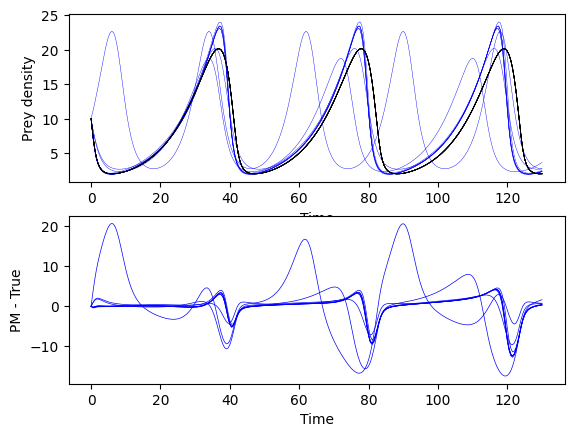

In [13]:
pm_op = []
for i in range(9):
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, 261))
  term = diffrax.ODETerm(simple_vector_field)
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  pm_op.append(sol.ys[0])
  pm_time = sol.ts

fig, ax = plt.subplots(2)
for i in range(9):
  ax[0].plot(pm_time, pm_op[i], lw=.3, color="blue", label="PM predictions")
  ax[0].plot(pm_time, true_op, lw=0.5, color="black", label="True values")
  ax[0].set_xlabel('Time')
  ax[0].set_ylabel('Prey density')

  ax[1].plot(pm_time, pm_op[i] - true_op, lw=0.5, color="blue")
  ax[1].set_xlabel('Time')
  ax[1].set_ylabel('PM - True')

In [14]:
# LOO CV with PiNN and NN
layer_sizes = [3 , 50, 50, 1]
param_scale = 1.0
train_iters= 200000


allpp_params = []
allmlp_params = []
for i in range(9):

  obscv = obs[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = idxcv)
  term = diffrax.ODETerm(simple_vector_field)
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  # prepare inputs
  inputs = obscv[:-1]
  targets = obscv[1:]
  rop = sol.ys[0]
  yh = rop[:-1]
  inputs = jnp.reshape(inputs, (7,1))
  targets = jnp.reshape(targets, (7,1))
  yh = jnp.reshape(yh, (7,1))
  inputs=jnp.hstack((inputs, jnp.reshape(idxcv[:-1], (7,1)), jnp.reshape(idxcv[1:], (7,1))))

  pp_params = init_random_params(param_scale, layer_sizes)
  mlp_params = init_random_params(param_scale, layer_sizes)
  os = adam.init(pp_params)
  mlp_os = adam.init(pp_params)
  losses=[]
  mlp_losses = []
  for i in range(train_iters):
    pp_params, os, loss = pp_update_adam(pp_params, os, inputs, yh, targets)
    losses.append(loss)
    mlp_params, mlp_os, mlp_loss = mlp_update_adam(mlp_params, mlp_os, inputs, targets)
    mlp_losses.append(mlp_loss)
  allpp_params.append(pp_params)
  allmlp_params.append(mlp_params)
  print(loss, mlp_loss)

1.1640575e-08 2.8132337e-05
2.2279967e-07 5.3366147e-08
8.807419e-08 1.2171527e-08
3.8504313e-06 7.5132384e-10
1.2264774e-08 2.8531338e-10
6.674542e-08 2.0368622e-09
1.1774709e-12 1.0810109e-07
9.34181e-11 1.6891015e-08
6.7663973e-12 3.4268463e-12


In [15]:
# Average create figure with mean and cv preds
pred_pm_sparse = np.empty(shape=(7,9))
pred_mlp_sparse = np.empty(shape=(7,9))
pred_pp_sparse = np.empty(shape=(7,9))

pred_pm_full = np.empty(shape=(260,9))
pred_mlp_full = np.empty(shape=(260,9))
pred_pp_full = np.empty(shape=(260,9))

idx_sparse = np.empty(shape=(7,9))
obs_sparse = np.empty(shape=(7,9))

for i in range(9):
  obscv = obs[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  obs_sparse[:,i] = obscv[1:]
  idx_sparse[:,i] = idxcv[1:]
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = idxcv)
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  # prepare inputs
  inputs = obscv[:-1]
  targets = obscv[1:]
  rop = sol.ys[0]

  pred_pm_sparse[:,i] = rop[1:]

  yh = rop[:-1]
  inputs = jnp.reshape(inputs, (7,1))
  targets = jnp.reshape(targets, (7,1))
  yh = jnp.reshape(yh, (7,1))
  inputs=jnp.hstack((inputs, jnp.reshape(idxcv[:-1], (7,1)), jnp.reshape(idxcv[1:], (7,1))))
  fine_inputs = inputs

  pred_pp_sparse[:,i] = np.reshape(parphy(allpp_params[i], fine_inputs, yh), (7,))
  pred_mlp_sparse[:,i] = np.reshape(naive(allmlp_params[i], fine_inputs, None), (7,))


  ip = jnp.hstack((jnp.reshape(true_op[:-1], (260,1)),  jnp.reshape(true_time[:-1], (260,1)), jnp.reshape(true_time[1:], (260,1)))) #jnp.reshape(true_time[1:] - true_time[:-1], (99,1))))
  yha = jnp.reshape(pm_op[i][:-1], (260,1))

  pred_pp_full[:,i] = np.reshape(parphy(allpp_params[i], ip, yha), (260,))
  pred_mlp_full[:,i] = np.reshape(naive(allmlp_params[i], ip, None), (260,))
  pred_pm_full[:,i] = np.reshape(pm_op[i][1:], (260,))

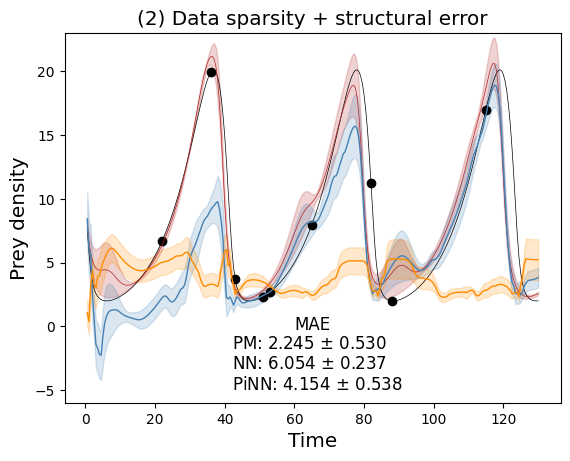

In [16]:
pm_full_mn = jnp.mean(pred_pm_full, axis=1)
pm_full_sd = jnp.std(pred_pm_full, axis=1)
mlp_full_mn = jnp.mean(pred_mlp_full, axis=1)
mlp_full_sd = jnp.std(pred_mlp_full, axis=1)
pp_full_mn = jnp.mean(pred_pp_full, axis=1)
pp_full_sd = jnp.std(pred_pp_full, axis=1)

pm_mae = jnp.array([jnp.mean(abs(pred_pm_full[:,j] - true_op[1:])) for j in range(9)])
mlp_mae = jnp.array([jnp.mean(abs(pred_mlp_full[:,j] - true_op[1:])) for j in range(9)])
pp_mae = jnp.array([jnp.mean(abs(pred_pp_full[:,j] - true_op[1:])) for j in range(9)])

fig, ax = plt.subplots(1)
ax.plot(true_time[1:], true_op[1:], lw=0.5, color='black', label="True dynamics")

ax.fill_between(true_time[1:], (pm_full_mn + pm_full_sd/jnp.sqrt(9)), (pm_full_mn - pm_full_sd/jnp.sqrt(9)), color="firebrick", alpha=0.2)
ax.plot(true_time[1:], pm_full_mn, lw=0.5, color='firebrick', label="PM")

ax.fill_between(true_time[1:], (pp_full_mn + pp_full_sd/jnp.sqrt(9)), (pp_full_mn - pp_full_sd/jnp.sqrt(9)), color="steelblue", alpha=0.2)
ax.plot(true_time[1:],  pp_full_mn, lw=1, color='steelblue', label="PiNN")

ax.fill_between(true_time[1:], (mlp_full_mn + mlp_full_sd/jnp.sqrt(9)),  (mlp_full_mn - mlp_full_sd/jnp.sqrt(9)), color="darkorange", alpha=0.2)
ax.plot(true_time[1:],  mlp_full_mn, lw=1, color='darkorange', label="NN")

ax.scatter(sparse_idx, obs, color="black", label="Observations")
ax.text(60, -0.3, "MAE",fontsize='large', fontweight="roman")
ax.text(42, -5, r"PM: {er:.3f} $\pm$ {se:.3f}" "\n" r"NN: {erm:.3f} $\pm$ {sem:.3f}""\n" r"PiNN: {erp:.3f} $\pm$ {sep:.3f}".format(
    er=jnp.mean(pm_mae), se=jnp.std(pm_mae)/jnp.sqrt(9),
    erm=jnp.mean(mlp_mae), sem=jnp.std(mlp_mae)/jnp.sqrt(9),
    erp=jnp.mean(pp_mae), sep=jnp.std(pp_mae)/jnp.sqrt(9)), fontsize='large')
ax.set_xlabel("Time", fontsize='x-large')
ax.set_ylabel("Prey density", fontsize='x-large')
ax.set_ylim(-6,23)
ax.set_title("(2) Data sparsity + structural error", fontsize='x-large', fontweight="roman")
fig.savefig(fname="results_exp2.svg", format="svg")

# (3) Data sparsity + structural error + noisy observations

In [17]:
obs_noisy = obs + npr.RandomState(1).normal(0,.5,9)

In [18]:
# LOO CV
pm_all = []
for i in range(9):
  obscv = obs_noisy[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  train_iters=60000
  pm_params = jnp.array((0.1, .02, .4) + npr.RandomState(5).normal(0,.01, 3))
  os = adam.init(pm_params)
  losses = []
  for i in range(train_iters):
    pm_params, os, loss = pm_update_adam(pm_params, os, obscv, idxcv)
    losses.append(loss)
  pm_all.append(pm_params)
  print(loss)

0.40878624
0.31732333
0.6248529
0.6311952
36.390312
0.6076948
1.0001853
12.169183
0.50137895


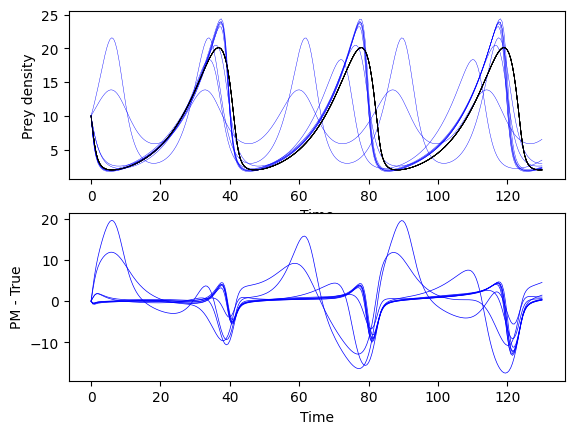

In [19]:
pm_op = []
for i in range(9):
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = jnp.linspace(t0, t1, 261))
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  pm_op.append(sol.ys[0])
  pm_time = sol.ts


fig, ax = plt.subplots(2)
for i in range(9):
  ax[0].plot(pm_time, pm_op[i], lw=.3, color="blue", label="PM predictions")
  ax[0].plot(pm_time, true_op, lw=0.5, color="black", label="True values")
  ax[0].set_xlabel('Time')
  ax[0].set_ylabel('Prey density')

  ax[1].plot(pm_time, pm_op[i] - true_op, lw=0.5, color="blue")
  ax[1].set_xlabel('Time')
  ax[1].set_ylabel('PM - True')

In [20]:
# LOO CV with PiNN and NN
layer_sizes = [3 , 50, 50, 1]
param_scale = 1.0
train_iters= 200000

allpp_params = []
allmlp_params = []
for i in range(9):

  obscv = obs_noisy[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  args = pm_all[i] # true parameters (0.5, 0.005, 1, 0.01, 0.5)
  saveat = diffrax.SaveAt(ts = idxcv)
  term = diffrax.ODETerm(simple_vector_field)
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  # prepare inputs
  inputs = obscv[:-1]
  targets = obscv[1:]
  rop = sol.ys[0]
  yh = rop[:-1]
  inputs = jnp.reshape(inputs, (7,1))
  targets = jnp.reshape(targets, (7,1))
  yh = jnp.reshape(yh, (7,1))
  inputs=jnp.hstack((inputs, jnp.reshape(idxcv[:-1], (7,1)), jnp.reshape(idxcv[1:], (7,1))))

  pp_params = init_random_params(param_scale, layer_sizes)
  mlp_params = init_random_params(param_scale, layer_sizes)
  os = adam.init(pp_params)
  mlp_os = adam.init(pp_params)
  losses=[]
  mlp_losses = []
  for i in range(train_iters):
    pp_params, os, loss = pp_update_adam(pp_params, os, inputs, yh, targets)
    losses.append(loss)
    mlp_params, mlp_os, mlp_loss = mlp_update_adam(mlp_params, mlp_os, inputs, targets)
    mlp_losses.append(mlp_loss)
  allpp_params.append(pp_params)
  allmlp_params.append(mlp_params)
  print(loss, mlp_loss)

1.951622e-05 3.6464098e-08
1.0192219e-07 2.2088659e-07
8.7904293e-13 1.71052e-10
3.8695784e-06 0.0
15.029291 0.0
1.5473416e-08 3.0452185e-08
9.861927e-11 1.8796554e-08
3.4457263e-11 9.2540965e-08
3.6098507e-07 2.7836283e-08


In [21]:
# Average create figure with mean and cv preds
pred_pm_sparse = np.empty(shape=(7,9))
pred_mlp_sparse = np.empty(shape=(7,9))
pred_pp_sparse = np.empty(shape=(7,9))

pred_pm_full = np.empty(shape=(260,9))
pred_mlp_full = np.empty(shape=(260,9))
pred_pp_full = np.empty(shape=(260,9))

idx_sparse = np.empty(shape=(7,9))
obs_sparse = np.empty(shape=(7,9))

for i in range(9):
  obscv = obs_noisy[jnp.arange(0,9)!=i]
  idxcv = sparse_idx[jnp.arange(0,9)!=i]
  obs_sparse[:,i] = obscv[1:]
  idx_sparse[:,i] = idxcv[1:]
  args = pm_all[i]
  saveat = diffrax.SaveAt(ts = idxcv)
  sol = diffrax.diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
  # prepare inputs
  inputs = obscv[:-1]
  targets = obscv[1:]
  rop = sol.ys[0]

  pred_pm_sparse[:,i] = rop[1:]

  yh = rop[:-1]
  inputs = jnp.reshape(inputs, (7,1))
  targets = jnp.reshape(targets, (7,1))
  yh = jnp.reshape(yh, (7,1))
  inputs=jnp.hstack((inputs, jnp.reshape(idxcv[:-1], (7,1)), jnp.reshape(idxcv[1:], (7,1))))
  fine_inputs = inputs

  pred_pp_sparse[:,i] = np.reshape(parphy(allpp_params[i], fine_inputs, yh), (7,))
  pred_mlp_sparse[:,i] = np.reshape(naive(allmlp_params[i], fine_inputs, None), (7,))


  ip = jnp.hstack((jnp.reshape(true_op[:-1], (260,1)),  jnp.reshape(true_time[:-1], (260,1)), jnp.reshape(true_time[1:], (260,1)))) #jnp.reshape(true_time[1:] - true_time[:-1], (99,1))))
  yha = jnp.reshape(pm_op[i][:-1], (260,1))

  pred_pp_full[:,i] = np.reshape(parphy(allpp_params[i], ip, yha), (260,))
  pred_mlp_full[:,i] = np.reshape(naive(allmlp_params[i], ip, None), (260,))
  pred_pm_full[:,i] = np.reshape(pm_op[i][1:], (260,))



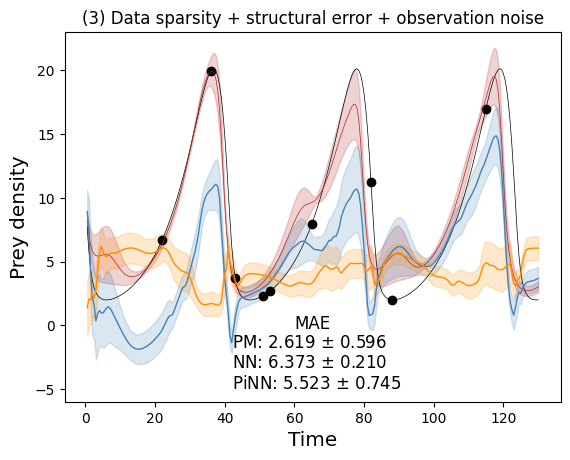

In [22]:
pm_full_mn = jnp.mean(pred_pm_full, axis=1)
pm_full_sd = jnp.std(pred_pm_full, axis=1)
mlp_full_mn = jnp.mean(pred_mlp_full, axis=1)
mlp_full_sd = jnp.std(pred_mlp_full, axis=1)
pp_full_mn = jnp.mean(pred_pp_full, axis=1)
pp_full_sd = jnp.std(pred_pp_full, axis=1)

pm_mae = jnp.array([jnp.mean(abs(pred_pm_full[:,j] - true_op[1:])) for j in range(9)])
mlp_mae = jnp.array([jnp.mean(abs(pred_mlp_full[:,j] - true_op[1:])) for j in range(9)])
pp_mae = jnp.array([jnp.mean(abs(pred_pp_full[:,j] - true_op[1:])) for j in range(9)])

fig, ax = plt.subplots(1)
ax.plot(true_time[1:], true_op[1:], lw=0.5, color='black', label="True dynamics")

ax.fill_between(true_time[1:], (pm_full_mn + pm_full_sd/jnp.sqrt(9)), (pm_full_mn - pm_full_sd/jnp.sqrt(9)), color="firebrick", alpha=0.2)
ax.plot(true_time[1:], pm_full_mn, lw=0.5, color='firebrick', label="PM")

ax.fill_between(true_time[1:], (pp_full_mn + pp_full_sd/jnp.sqrt(9)), (pp_full_mn - pp_full_sd/jnp.sqrt(9)), color="steelblue", alpha=0.2)
ax.plot(true_time[1:],  pp_full_mn, lw=1, color='steelblue', label="PiNN")

ax.fill_between(true_time[1:], (mlp_full_mn + mlp_full_sd/jnp.sqrt(9)),  (mlp_full_mn - mlp_full_sd/jnp.sqrt(9)), color="darkorange", alpha=0.2)
ax.plot(true_time[1:],  mlp_full_mn, lw=1, color='darkorange', label="NN")

ax.scatter(sparse_idx, obs, color="black", label="Observations")
ax.text(60, -0.3, "MAE",fontsize='large', fontweight="roman")
ax.text(42, -5, r"PM: {er:.3f} $\pm$ {se:.3f}" "\n" r"NN: {erm:.3f} $\pm$ {sem:.3f}""\n" r"PiNN: {erp:.3f} $\pm$ {sep:.3f}".format(
    er=jnp.mean(pm_mae), se=jnp.std(pm_mae)/jnp.sqrt(9),
    erm=jnp.mean(mlp_mae), sem=jnp.std(mlp_mae)/jnp.sqrt(9),
    erp=jnp.mean(pp_mae), sep=jnp.std(pp_mae)/jnp.sqrt(9)), fontsize='large')
ax.set_xlabel("Time", fontsize='x-large')
ax.set_ylabel("Prey density", fontsize='x-large')
ax.set_ylim(-6,23)
ax.set_title("(3) Data sparsity + structural error + observation noise")
fig.savefig(fname="results_exp3.svg", format="svg")